**<span style="color: #808080;">In The Name of God</span>**

---

**<span style="color: #808080;">Mani hosseini</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102552</span>**<br>
**<span style="color: #808080;">Parsa Bukani</span>** <br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102501</span>**<br>
**<span style="color: #808080;">Erfan Falahati</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102491</span>**

# <span style="color:rgb(143, 0, 255);">Task #1</span>
# <span style="color: #8F00FF;">**Classification**
</span>


## <span style="color: #8F00FF;">**EDA**

### <span style="color: #8F00FF;">**loading stuff**

In [153]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


df = pd.read_csv('content/cancer_patients/train_data.csv')



### <span style="color: #8F00FF;">**Checking birthdate Distribution**


<img src="content\images\birthdate.png" width="2000" alt="Description">

### <span style="color: #8F00FF;">**Effect of occuption  on survival rate**:
it seems factory worker survive less than others so a flag for if the person is a factory worker might be a good idea.

<img src="content\images\occuption.png" width="2000" alt="Description">

### <span style="color: #8F00FF;">**Stage-label relation**:
it seems IV and III are deadlier than I and II while there isnt much difference between I nd II(added an early stage label)

<img src="content\images\stages.png" width="2000" alt="Description">


### <span style="color: #8F00FF;">**Survival  rate of different cancer types**:
it seems some cancer are more dangerous than others, target encoding it might be useful.

<img src="content\images\cancer_types.png" width="2000" alt="Description">


## <span style="color: #8F00FF;">**Preprocessing & Feature Engineering**:

### <span style="color: #8F00FF;">**proccesing NaN values**

#### <span style="color: #8F00FF;">**checking number of NaN values**

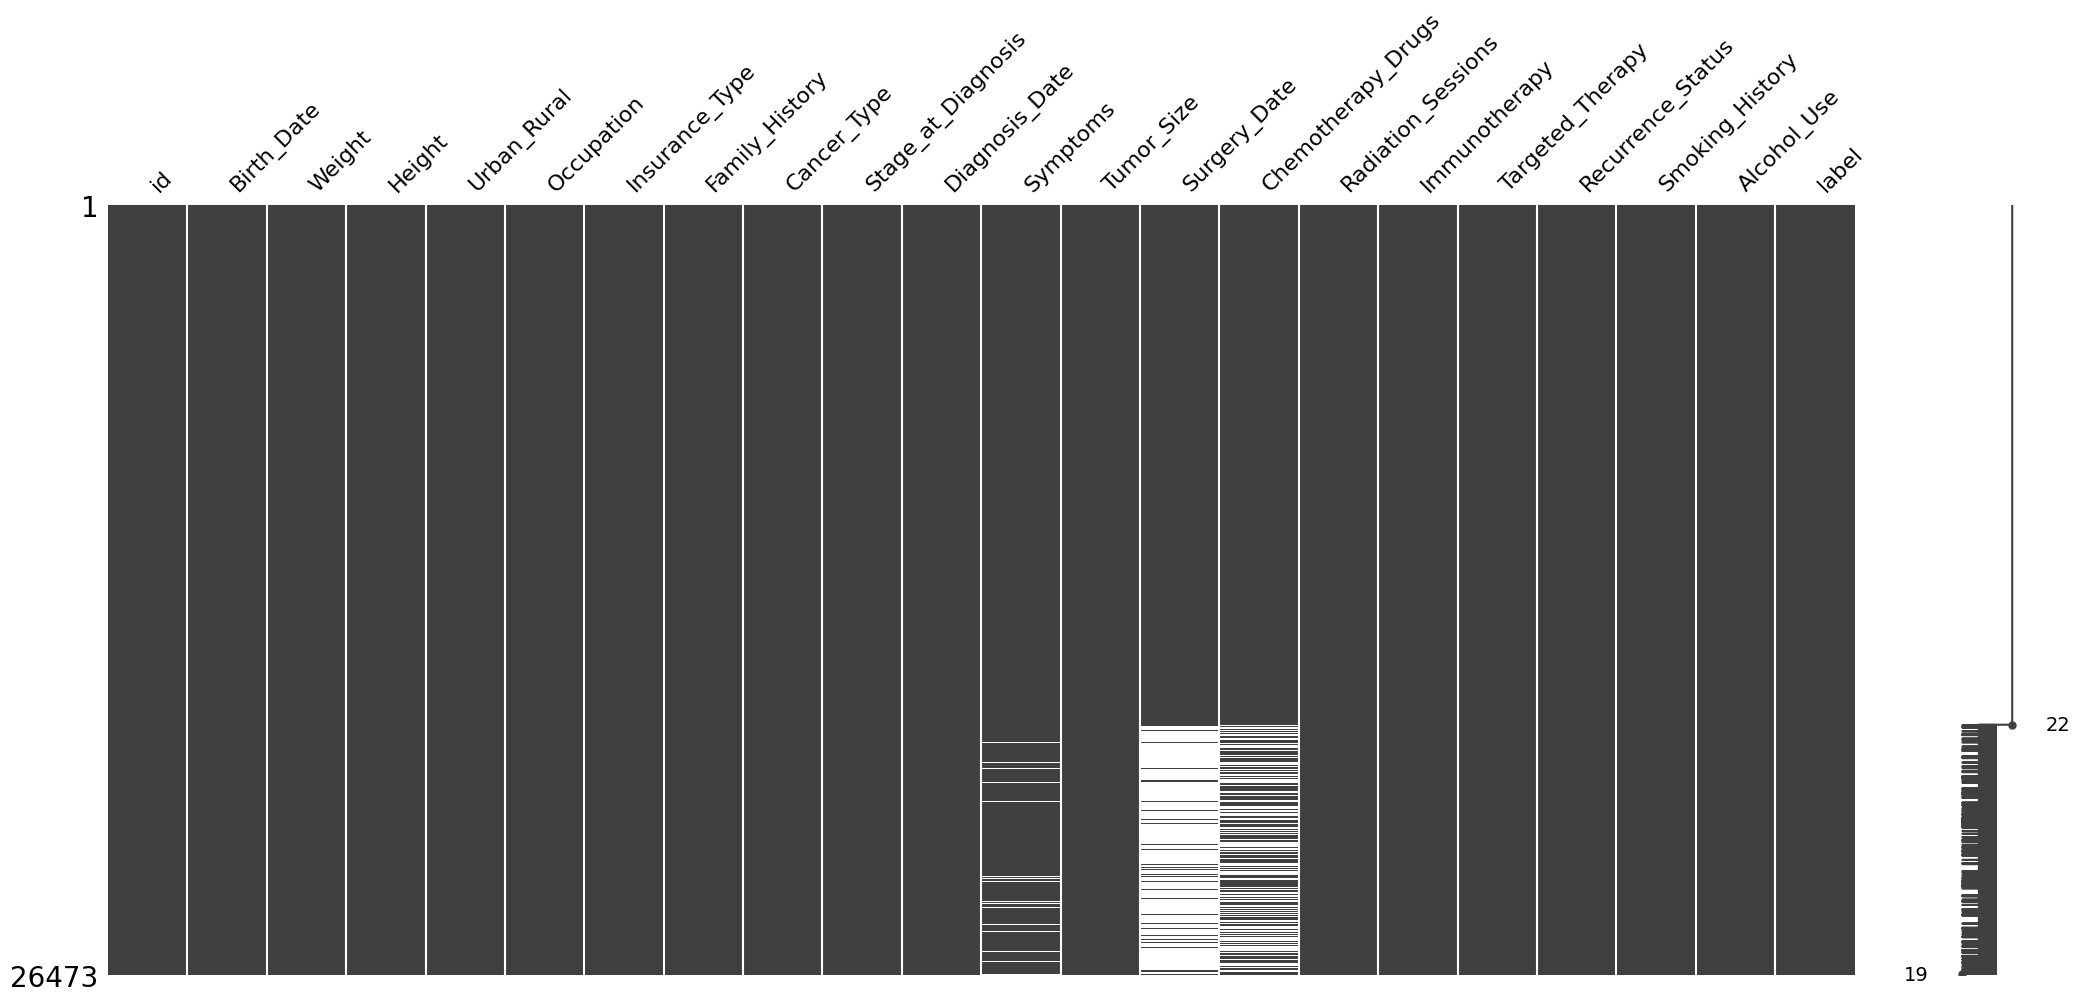

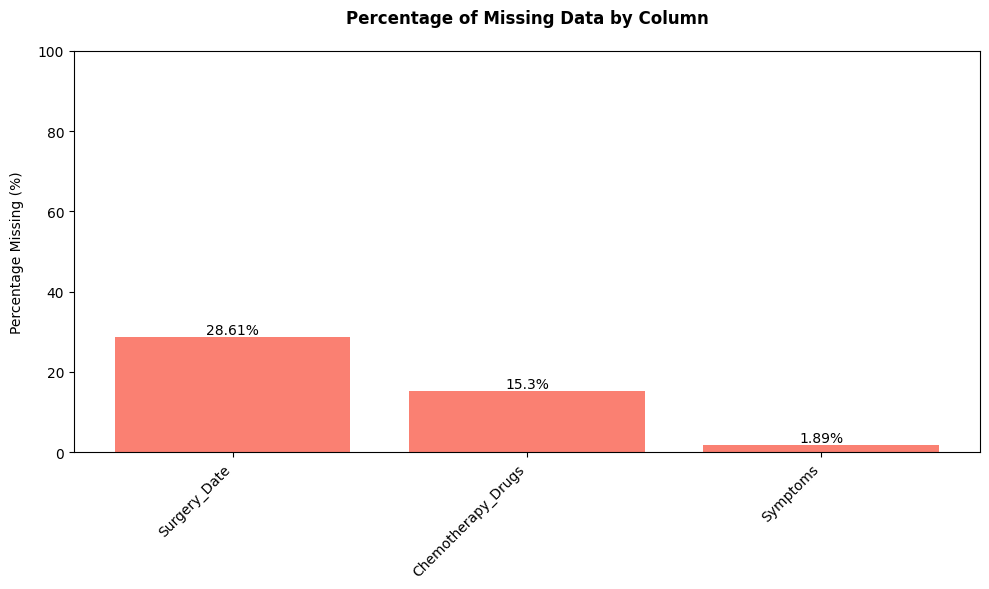

                    Missing Values  Percentage (%)
Surgery_Date                  7575           28.61
Chemotherapy_Drugs            4050           15.30
Symptoms                       501            1.89


In [154]:
msno.matrix(df)
plt.show()


def show_missing_data(df):
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100

    missing_df = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage (%)': missing_percent.round(2)
    })
    
    missing_df = missing_df[missing_df['Missing Values'] > 0]
    
    missing_df = missing_df.sort_values('Percentage (%)', ascending=False)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(missing_df.index, missing_df['Percentage (%)'], color='salmon')
    plt.title('Percentage of Missing Data by Column', pad=20, weight='bold')
    plt.ylabel('Percentage Missing (%)', labelpad=10)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return missing_df

missing_stats = show_missing_data(df)
print(missing_stats)

#### <span style="color: #8F00FF;">**getting insights from NaN values** <br>
here we checked if there is an imbalance between groups that have NaN as their chemo or surgery value

In [155]:




# Check if surgery/chemo missingness relates to outcomes
print("rate of people who didnt have surgery and survived: ",df[df['Surgery_Date'].isna()]['label'].mean())  
print("rate of people who had surgery and survived",df[df['Surgery_Date'].notna()]['label'].mean()) 

print("rate of people who had chemo and survived: ",df[df['Chemotherapy_Drugs'].notna()]['label'].mean())


print("Stage distribution for patients WITH chemo: ")
print(df[df['Chemotherapy_Drugs'].notna()]['Stage_at_Diagnosis'].value_counts(normalize=True))

print("\nStage distribution for patients WITHOUT chemo:")
print(df[df['Chemotherapy_Drugs'].isna()]['Stage_at_Diagnosis'].value_counts(normalize=True))




rate of people who didnt have surgery and survived:  0.4778877887788779
rate of people who had surgery and survived 0.4888877129855011
rate of people who had chemo and survived:  0.4864201935512643
Stage distribution for patients WITH chemo: 
Stage_at_Diagnosis
II     0.263881
III    0.260402
IV     0.239174
I      0.236543
Name: proportion, dtype: float64

Stage distribution for patients WITHOUT chemo:
Stage_at_Diagnosis
III    0.299506
II     0.289877
IV     0.205679
I      0.204938
Name: proportion, dtype: float64


#### <span style="color: #8F00FF;">**replacing NaN value with something useful**:
- for both surgery date and chemo drugs added a bool columns that if they had surgery or chemo drugs at all
- filled NaN values in chemo drugs with None because there is an small percentage of NaN values in that column, also there is a good chance that some people didnt need chemo drugs
- if Symptom column is emoty lets assume  unkown for now. 


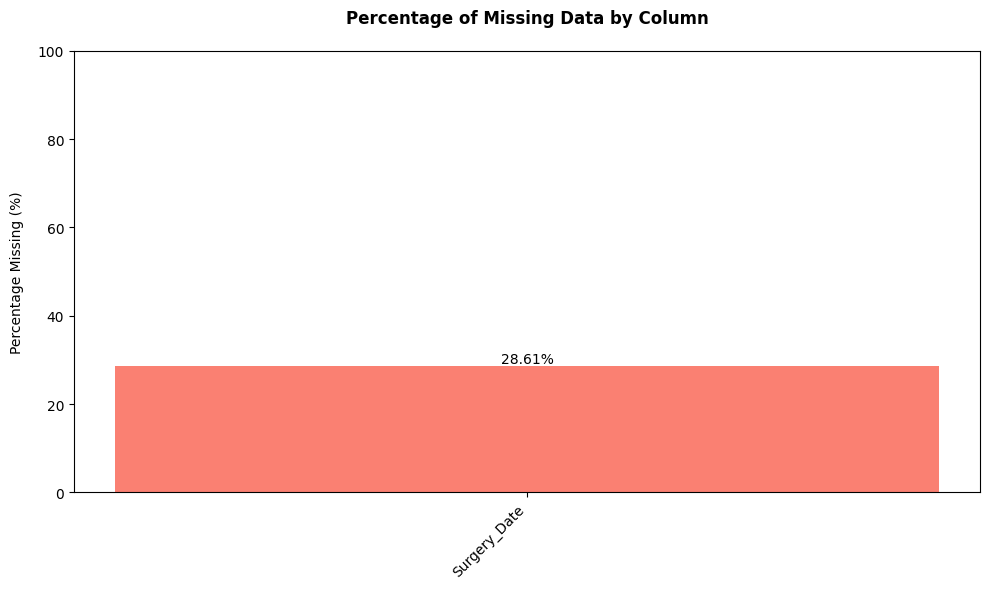

              Missing Values  Percentage (%)
Surgery_Date            7575           28.61


In [156]:

df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)

df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)



#NaN values here are  probably because they havent had chemo drugs
df['Chemotherapy_Drugs'] = df['Chemotherapy_Drugs'].fillna('None')


# set no symptoms to unknown for now
df['Symptoms'] = df['Symptoms'].fillna('Unknown')


# Calculate days from diagnosis to surgery (if surgery occurred)
df['Days_to_Surgery'] = (pd.to_datetime(df['Surgery_Date']) - pd.to_datetime(df['Diagnosis_Date'])).dt.days
df['Days_to_Surgery'] = df['Days_to_Surgery'].fillna(-1)  # -1 = no surgery
#maybe 100000 worked better


def surgery_timing(x):
    if x == -1:
        return 0  # No surgery
    elif x < 0:
        return 1  # Surgery before diagnosis
    elif x < 30:
        return 2  # Early surgery
    else:
        return 3  # Late surgery

df['Surgery_Timing'] = df['Days_to_Surgery'].apply(surgery_timing)
# tested this,wasnt useful

missing_stats = show_missing_data(df)
print(missing_stats)

### <span style="color: #8F00FF;">**fixing birthdates and surgery dates**: 
there were 87 entries were birthdates were 1800 , all of them were all.<br>
also there are 4000 entries where surgery date is before diagnosis. two versions of dataset where made in one surgery date is ignored and in the other rows with negative days to surgery is dropped. 

In [157]:
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer



# converting dates
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], errors='coerce')
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], errors='coerce')


# adding age when diagnosed
df['Age'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days // 365



#check out many people negative days to surgery values
print("Rows with negative days to surgery")
print(df[df['Days_to_Surgery'] < -1][['id', 'Diagnosis_Date', 'Surgery_Date', 'Days_to_Surgery',"label"]])

df = df[df['Birth_Date'].notna()]




df['Height'] = df['Height'].replace(r'[^\d.]', '', regex=True).astype(float)
df['Weight'] = df['Weight'].replace(r'[^\d.]', '', regex=True).astype(float)




#clean 1800 guys
df = df[(df['Age'] > 0) & (df['Age'] < 120)]


# print("\nAge distribution:")
# print(df['Age'].describe())





Rows with negative days to surgery
          id Diagnosis_Date Surgery_Date  Days_to_Surgery  label
9         10     2018-07-31   2013-12-19          -1685.0      0
14        15     2021-10-11   2021-05-11           -153.0      0
15        16     2023-12-21   2022-08-19           -489.0      1
16        17     2017-10-15   2011-09-17          -2220.0      1
19        20     2020-05-19   2018-02-18           -821.0      1
...      ...            ...          ...              ...    ...
25877  25878     2022-11-29   2022-07-28           -124.0      0
25879  25880     2018-09-07   2018-05-01           -129.0      0
25997  25998     2018-07-15   2018-06-29            -16.0      1
26069  26070     2019-05-28   2019-03-06            -83.0      1
26354  26355     2023-04-26   2023-04-22             -4.0      0

[4679 rows x 5 columns]



### <span style="color: #8F00FF;">**Basic Feature Engineering**: 




#### <span style="color: #8F00FF;">**adding  new feature**: 
 - BMI was calculated (and later checked using corr  matrix to see if it is worth keeping or not) <br>
 - count of drugs each person took was calculated. <br>
  - drugs were seprated  and one hot encoded properly. <br>
  - new flag were made from EDA(to seprate extreme cases) 


In [158]:
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

# BMI
df['BMI'] = df['Weight'] / (df['Height']/100)**2




df['Drug_Count'] = df['Chemotherapy_Drugs'].apply(
    lambda x: 0 if x == 'None' else len(x.split(','))
)










df['Drugs_List'] = df['Chemotherapy_Drugs'].apply(
    lambda x: [drug.strip() for drug in x.split(',')] if x != 'None' else []
)
mlb = MultiLabelBinarizer()
drug_encoded = pd.DataFrame(
    mlb.fit_transform(df['Drugs_List']),
    columns=[f"Drug_{drug}" for drug in mlb.classes_],
    index=df.index
)
df = pd.concat([df, drug_encoded], axis=1)


df['Is_Factory_Worker'] = (df['Occupation'] == 'Factory Worker').astype(int)
df['Is_Early_Stage'] = df['Stage_at_Diagnosis'].isin(['I', 'II']).astype(int)
df['Is_Stage_IV'] = (df['Stage_at_Diagnosis'] == 'IV').astype(int)



# bs features dont try
# df['BMI_X_Stage'] = df['BMI'] * df['Stage_at_Diagnosis']
# df['Age_X_Stage'] = df['Age'] * df['Stage_at_Diagnosis']
# df['Is_Stage_IV_X_Factory'] = df['Is_Factory_Worker'] * (df['Stage_at_Diagnosis'] == 4).astype(int)
# df['Cancer_Deadliness'] = df['Cancer_Type'].map(cancer_survival)
# df['Treatment_Intensity'] = df['Radiation_Sessions'] * df['Drug_Count']
# df['Surgery_Response'] = df['Days_to_Surgery'].apply(
#     lambda x: 0 if x == -1 else (1 if x < 30 else 2)) 
# df['Performance_Score'] = (
#     df['Age']/10 + 
#     df['Stage_at_Diagnosis']*2 + 
#     (df['BMI'] < 18.5).astype(int)*3
# )














  
#### <span style="color: #8F00FF;">**encoding ordinals**:
 - ordinal features were encoded properly <br>

In [159]:

roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
df['Stage_at_Diagnosis'] = df['Stage_at_Diagnosis'].str.extract(r'([IV]+)')[0].map(roman_to_int)







occupation_rank = {
    'Unemployed': 4,
    'Retired': 3,
    'Farmer': 2,
    'Office Worker': 1,
    'Factory Worker': 5
}

# occupation_rank = {
#     'Unemployed': 2,
#     'Retired': 5,
#     'Farmer': 4,
#     'Office Worker': 3,
#     'Factory Worker': 1
# }

# occupation_rank = {
#     'Unemployed': 2,
#     'Retired': 3,
#     'Farmer': 3,
#     'Office Worker': 2,
#     'Factory Worker': 1
# }









df['Occupation'] = df['Occupation'].map(occupation_rank).fillna(0).astype(int)



smoke_rank = {
    'Never': 1,
    'Former': 2,
    'Current': 3,
}
df['Smoking_History'] = df['Smoking_History'].map(smoke_rank).astype(int)



alcohol_rank = {
    'Never': 1,
    'Occasional': 2,
    'Regular': 3,
}
df['Alcohol_Use'] = df['Alcohol_Use'].map(alcohol_rank).astype(int)




cancer_rank = {
    'Lung': 1,
    'Esophageal': 2,
    'Stomach': 2,
    'Colorectal': 3,
    "Cervical":4,
    "Liver": 4,
    "Breast":5
}
df['Cancer_Type'] = df['Cancer_Type'].map(cancer_rank).astype(int)




  
#### <span style="color: #8F00FF;">**target encoding cancer types**:
 - from EDA we know cancers kinda have an order(basically like a deadliness order) <br>

In [160]:
cancer_target_means = df.groupby('Cancer_Type')['label'].mean().to_dict()
df['Cancer_Type_Encoded'] = df['Cancer_Type'].map(cancer_target_means)
print(cancer_target_means)

{1: 0.36116803278688525, 2: 0.44898230677131834, 3: 0.4708686440677966, 4: 0.540301908288237, 5: 0.589872810175186}


  
#### <span style="color: #8F00FF;">**encoding binaries**:
 - binary  features were encoded properly <br>

In [161]:
df['Urban_Rural'] = df['Urban_Rural'].str.lower().map({'urban': 1, 'rural': 0})
df['Family_History'] = df['Family_History'].str.lower().map({'yes': 1, 'no': 0})
df['Immunotherapy'] = df['Immunotherapy'].str.lower().map({'yes': 1, 'no': 0})
df['Targeted_Therapy'] = df['Targeted_Therapy'].str.lower().map({'yes': 1, 'no': 0})
df['Recurrence_Status'] = df['Recurrence_Status'].str.lower().map({'yes': 1, 'no': 0})

  
#### <span style="color: #8F00FF;">**checking the final preprocessed data**:

In [162]:

print(df.describe())
df_with_surgery = df.copy()

# df_with_surgery.head()
# df_with_surgery.hist(bins=50,figsize=(12,8))
# plt.show()


#since the test has the error of diagnosis date happening  after suregery date , it is better to not use this.
df_clean_surgery = df[df['Days_to_Surgery'] >= -1].copy()
# df_clean_surgery.describe()

                 id                     Birth_Date        Weight  \
count  26386.000000                          26386  26386.000000   
mean   13235.928977  1968-12-15 06:16:37.074206020     73.799598   
min        1.000000            1935-01-01 00:00:00     31.500000   
25%     6617.250000            1950-11-05 12:00:00     57.000000   
50%    13238.500000            1967-09-22 12:00:00     72.100000   
75%    19855.750000            1986-05-23 00:00:00     88.400000   
max    26473.000000            2007-12-27 00:00:00    133.100000   
std     7642.678012                            NaN     21.358527   

             Height   Urban_Rural    Occupation  Family_History   Cancer_Type  \
count  26386.000000  26386.000000  26386.000000    26386.000000  26386.000000   
mean     172.476427      0.538316      2.994618        0.425870      3.001175   
min      150.000000      0.000000      1.000000        0.000000      1.000000   
25%      161.000000      0.000000      2.000000        0.000000

## <span style="color: #8F00FF;">**Model training and evalution**:


### <span style="color: #8F00FF;">**Selecting Features**: 
here features are seprated and train test split is performed.

In [163]:

from sklearn.model_selection import train_test_split




# ordinal_features = [
#     'Stage_at_Diagnosis', 
#     'Occupation',        
#     'Cancer_Type',     
#     'Smoking_History',
#     'Alcohol_Use'
# ]

# # Nominal features (no inherent order)
# nominal_features = [
#     'Urban_Rural',
#     'Insurance_Type',
#     'Family_History',
#     'Had_Surgery',
#     'Had_Chemotherapy',
#     'Immunotherapy',
#     'Targeted_Therapy', 
#     'Recurrence_Status',
#     'Is_Factory_Worker',
#     'Is_Early_Stage',
    
# ] + list(drug_encoded.columns) 


# numerical_features = [
#     'Weight', 'Height', 'Age', 
#     'Radiation_Sessions', 'Tumor_Size', 'BMI',
#     'Days_to_Surgery'
# ]



ordinal_features = [
    'Stage_at_Diagnosis', 
    'Cancer_Type',     
    'Smoking_History',
    'Alcohol_Use'
]

# Nominal features (no inherent order)
nominal_features = [
    'Urban_Rural',
    'Insurance_Type',
    'Family_History',
    'Had_Surgery',    'Occupation',
    'Had_Chemotherapy',
    'Immunotherapy', 
    'Recurrence_Status',
    'Is_Factory_Worker',
    'Surgery_Timing'
    
] + list(drug_encoded.columns) 


numerical_features = [
    'Weight', 'Height', 'Age', 
    'Radiation_Sessions', 'Tumor_Size', 'BMI',
    'Days_to_Surgery'
    # 'Cancer_Type_Encoded'
]





y = df_with_surgery['label']






X = df_with_surgery[numerical_features +nominal_features+ordinal_features]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")
print("Class balance in train:", y_train.value_counts(normalize=True))






Train size: (21108, 33), Test size: (5278, 33)
Class balance in train: label
0    0.514307
1    0.485693
Name: proportion, dtype: float64



#### <span style="color: #8F00FF;">**checking corr matrix**: 
correlation matrix is plotted to see how features effect the outcome and drop features if needed. 

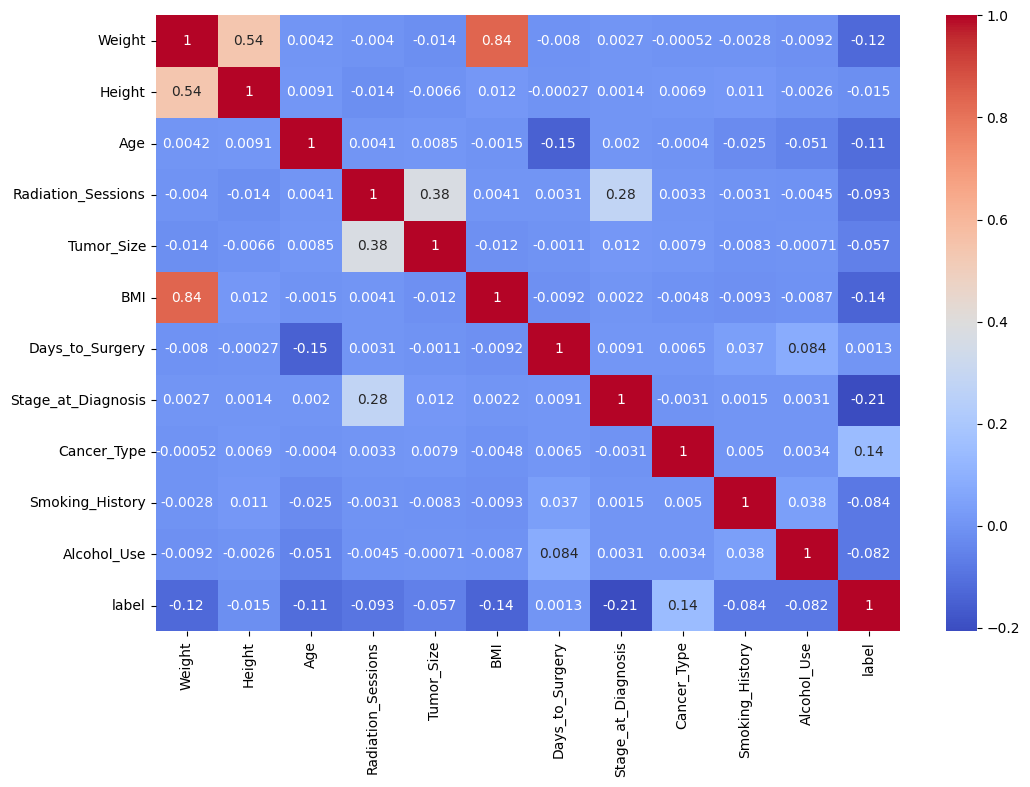

In [164]:

plt.figure(figsize=(12,8))
sns.heatmap((df_with_surgery[numerical_features+ordinal_features+["label"]]).corr(), annot=True, cmap='coolwarm')
plt.show()

#### <span style="color: #8F00FF;">**Applying column transfer:**

In [165]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features+ordinal_features),
    ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)],
    remainder='passthrough'
)

#### <span style="color: #8F00FF;">**Creating piplines and testing:**

In [166]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.inspection import permutation_importance




xgb_model = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        scale_pos_weight=sum(y_train==0)/sum(y_train==1),  # Handle class imbalance
        random_state=42,
        eval_metric='auc',
        learning_rate=0.009884850793730734,max_depth=8, n_estimators=445, subsample= 0.698567141638336, colsample_bytree= 0.9210776442460646, gamma=0.9999029437049183
    ))
])



param_dist = {
    'clf__n_estimators': randint(100, 500),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__subsample': uniform(0.5, 0.5),
    'clf__colsample_bytree': uniform(0.5, 0.5),
    'clf__gamma': uniform(0, 5)
}

search = RandomizedSearchCV(
    xgb_model,  # your pipeline from earlier
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=30,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)



xgb_params = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}


xgb_grid= GridSearchCV(xgb_model, xgb_params, cv=3, scoring='roc_auc', n_jobs=-1)


# Logistic Regression
lr_model = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegressionCV(
        Cs=10,  # Try 10 regularization strengths
        cv=5,
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        scoring='roc_auc'
    ))
])


# Logistic Regression CV
lr_cv_model = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegressionCV(
        Cs=10,  # Try 10 regularization strengths
        cv=5,
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        scoring='roc_auc'
    ))
])


# LGBM 
lgbm_model = Pipeline([
    ('pre', preprocessor),
    ('clf', LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        metric='auc',
        n_estimators=200,
        max_depth=5
    ))
])




catboost_model = Pipeline([
    ('pre', preprocessor),
    ('clf', CatBoostClassifier(
        iterations=429,
        depth=9,
        learning_rate=0.01070956845958623,
        random_state=42,
        l2_leaf_reg= 0.164160631870976,
        border_count=200

    ))
])

rf_model = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        class_weight='balanced',
        random_state=42
    ))
])

gbm_model = Pipeline([
    ('pre', preprocessor),
    ('clf', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])


# Train and evaluate both models
# models=[('Logistic Regression', lr_model), ('XGBoost', xgb_model),('XGBoost with random search', search),('Logistic Regression CV',lr_cv_model),('LGBM',lgbm_model),('XGB with grid search',xgb_grid),('Gradient Boosting',gbm_model),('Random Forest',rf_model),('Cat Boost',catboost_model)]

# models=[('Cat Boost',catboost_model), ('XGBoost', xgb_model),('XGBoost with random search', search)]
# for name, model in models:
#     print(f"\n=== {name} ===")
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)[:, 1]
    
#     print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
#     print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
#     print("Confusion Matrix:")
#     print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
    
#     # Feature Importance (model-specific)
#     plt.figure(figsize=(12, 8))
    
#     if 'XGB' in name or 'Cat' in name or 'LGBM' in name:
#         # For tree-based models
#         if name == 'Cat Boost':
#             # CatBoost feature importance
#             importance = model.named_steps['clf'].get_feature_importance()
#             feature_names = model.named_steps['pre'].get_feature_names_out()
#             pd.Series(importance, index=feature_names).sort_values(ascending=False).head(20).plot.barh()
#         else:
#             # XGBoost/LightGBM
#             if name == 'XGBoost':
#                 xgb.plot_importance(model.named_steps['clf'], max_num_features=20)
#             elif name == 'LGBM':
#                 lgb.plot_importance(model.named_steps['clf'], max_num_features=20)
#         plt.title(f'{name} Feature Importance')
        
#     elif 'Logistic' in name:
#         # For logistic regression - show coefficients
#         coefs = pd.Series(
#             model.named_steps['clf'].coef_[0],
#             index=model.named_steps['pre'].get_feature_names_out()
#         ).sort_values(key=abs, ascending=False).head(20)
#         coefs.plot.barh()
#         plt.title('Logistic Regression Top Coefficients (Absolute Value)')
    
#     plt.tight_layout()
#     plt.show()
    

#     if 'XGB' in name or 'Cat' in name or 'LGBM' in name:
#         if name == 'Cat Boost':
#             importance = pd.DataFrame({
#                 'feature': model.named_steps['pre'].get_feature_names_out(),
#                 'importance': model.named_steps['clf'].get_feature_importance()
#             }).sort_values('importance', ascending=False)
#         # else:
#         #     importance = pd.DataFrame({
#         #         'feature': model.named_steps['clf'].feature_names_in_,
#         #         'importance': model.named_steps['clf'].feature_importances_
#         #     }).sort_values('importance', ascending=False)
        
#         print("\nTop best Features:")
#         print(importance.head(20))
#         print("\nTop worst Features:")
#         print(importance.tail(20))



In [167]:
# import optuna
# from catboost import CatBoostClassifier
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import roc_auc_score, accuracy_score
# import pandas as pd

# # Assuming you have a DataFrame `df` and a target column `target`
# # X_train, X_test, y_train, y_test should be defined beforehand
# # Example:
# # X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, random_state=42)

# def objective(trial):
#     # Define the hyperparameters to optimize
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
#         'depth': trial.suggest_int('depth', 3, 15),
#         'iterations': trial.suggest_int('iterations', 50, 500),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e5, log=True),
#         'border_count': trial.suggest_int('border_count', 32, 255)
#     }
    
#     # Create the pipeline with preprocessor and model
#     model = Pipeline([
#         ('pre', preprocessor),  # Preprocessing step
#         ('clf', CatBoostClassifier(
#             scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),  # Handle class imbalance
#             random_state=42,
#             eval_metric='AUC',
#             verbose=False  # Disables verbose output during training
#         ))
#     ])
    
#     # Set the hyperparameters in the model
#     model.set_params(**params)
    
#     # Cross-validation score
#     score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
#     return score.mean()

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')

# # Optimize the objective function
# study.optimize(objective, n_trials=50)

# # Best hyperparameters
# print("Best hyperparameters: ", study.best_params)

# # Create the final model using the best parameters
# best_model = Pipeline([
#     ('pre', preprocessor),
#     ('clf', CatBoostClassifier(
#         scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
#         random_state=42,
#         eval_metric='AUC',
#         verbose=False,
#         **study.best_params  # Pass the best parameters found by Optuna
#     ))
# ])

# # Fit the model on the entire training data
# best_model.fit(X_train, y_train)

# # Predict on the test set
# y_pred = best_model.predict(X_test)
# y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # For AUC calculation

# # Evaluate the model's performance on the test set
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"Test ROC AUC: {roc_auc}")

# test_acc = accuracy_score(y_test, y_pred)
# print(f"\nTest accuracy: {test_acc:.4f}")


In [168]:
# import optuna
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import roc_auc_score
# from xgboost import XGBClassifier


# def objective(trial):
#     # Define the hyperparameters to optimize
#     params = {
#         'clf__learning_rate': trial.suggest_float('clf__learning_rate', 1e-5, 1e-1, log=True),
#         'clf__max_depth': trial.suggest_int('clf__max_depth', 3, 15),
#         'clf__n_estimators': trial.suggest_int('clf__n_estimators', 50, 500),
#         'clf__subsample': trial.suggest_float('clf__subsample', 0.5, 1.0),
#         'clf__colsample_bytree': trial.suggest_float('clf__colsample_bytree', 0.5, 1.0),
#         'clf__gamma': trial.suggest_float('clf__gamma', 0, 1),
#     }

    
#     # Create the pipeline with preprocessor and model
#     model = Pipeline([
#         ('pre', preprocessor),  # Preprocessing step
#         ('clf', XGBClassifier(
#             scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),  # Handle class imbalance
#             random_state=42,
#             eval_metric='auc',
#         ))
#     ])
    
#     # Set the hyperparameters in the model
#     model.set_params(**params)
    
#     # Cross-validation score
#     score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
#     return score.mean()

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')

# # Optimize the objective function
# study.optimize(objective, n_trials=50)

# # Best hyperparameters
# print("Best hyperparameters: ", study.best_params)

# # Create the final model using the best parameters
# best_model = Pipeline([
#     ('pre', preprocessor),
#     ('clf', XGBClassifier(
#         scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
#         random_state=42,
#         eval_metric='auc',
#         **study.best_params  # Pass the best parameters found by Optuna
#     ))
# ])

# # Fit the model on the entire training data
# best_model.fit(X_train, y_train)

# # Predict on the test set
# y_pred = best_model.predict(X_test)
# y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # For AUC calculation

# roc_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"Test ROC AUC: {roc_auc}")
# y_pred = best_model.predict(X_test)
# test_acc = accuracy_score(y_test, y_pred)
# print(f"\nTest accuracy: {test_acc:.4f}")


In [169]:
# import optuna
# from catboost import CatBoostClassifier
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import roc_auc_score
# import pandas as pd

# # Assuming you have a DataFrame `df` and a target column `target`
# # X_train, X_test, y_train, y_test should be defined beforehand
# # Example:
# # X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, random_state=42)

# def objective(trial):
#     # Define the hyperparameters to optimize
#     params = {
#         'clf__learning_rate': trial.suggest_float('clf__learning_rate', 1e-5, 1e-1, log=True),
#         'clf__depth': trial.suggest_int('clf__depth', 3, 15),
#         'clf__iterations': trial.suggest_int('clf__iterations', 50, 500),
#         'clf__l2_leaf_reg': trial.suggest_float('clf__l2_leaf_reg', 1e-5, 1e5, log=True),
#         'clf__border_count': trial.suggest_int('clf__border_count', 32, 255)
#     }
    
#     # Create the pipeline with preprocessor and model
#     model = Pipeline([
#         ('pre', preprocessor),  # Preprocessing step
#         ('clf', CatBoostClassifier(
#             scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),  # Handle class imbalance
#             random_state=42,
#             eval_metric='AUC',
#             verbose=False  # Disables verbose output during training
#         ))
#     ])
    
#     # Set the hyperparameters in the model
#     model.set_params(**params)
    
#     # Cross-validation score
#     score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
#     return score.mean()

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')

# # Optimize the objective function
# study.optimize(objective, n_trials=50)

# # Best hyperparameters
# print("Best hyperparameters: ", study.best_params)

# # Create the final model using the best parameters
# best_model = Pipeline([
#     ('pre', preprocessor),
#     ('clf', CatBoostClassifier(
#         scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
#         random_state=42,
#         eval_metric='AUC',
#         verbose=False,
#         **study.best_params  # Pass the best parameters found by Optuna
#     ))
# ])

# # Fit the model on the entire training data
# best_model.fit(X_train, y_train)

# # Predict on the test set
# y_pred = best_model.predict(X_test)
# y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # For AUC calculation

# # Evaluate the model's performance on the test set
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"Test ROC AUC: {roc_auc}")

# test_acc = accuracy_score(y_test, y_pred)
# print(f"\nTest accuracy: {test_acc:.4f}")


## <span style="color: #8F00FF;">**Testing real data**:

In [170]:

test_df = pd.read_csv('content/cancer_patients/test_data.csv')

def preprocess_data(df):
    df = df.copy()
    
    df['Symptoms'] = df['Symptoms'].fillna('Unknown')
    df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)
    df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)
    df['Chemotherapy_Drugs'] = df['Chemotherapy_Drugs'].fillna('None')
    df['Drug_Count'] = df['Chemotherapy_Drugs'].apply(
    lambda x: 0 if x == 'None' else len(x.split(','))
)
    df['Weight'] = pd.to_numeric(df['Weight'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
    df['Height'] = pd.to_numeric(df['Height'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
    
    df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], errors='coerce')
    df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], errors='coerce')
    df['Surgery_Date'] = pd.to_datetime(df['Surgery_Date'], errors='coerce')
    
    df['Age'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days // 365
    df['Days_to_Surgery'] = (df['Surgery_Date'] - df['Diagnosis_Date']).dt.days
    df['Days_to_Surgery'] = df['Days_to_Surgery'].fillna(100000)
    
    df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)
    
    
    df['Is_Early_Stage'] = df['Stage_at_Diagnosis'].isin(['I', 'II']).astype(int)
    
    roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
    df['Stage_at_Diagnosis'] = df['Stage_at_Diagnosis'].str.extract(r'([IV]+)')[0].map(roman_to_int)
    



    df['Is_Factory_Worker'] = (df['Occupation'] == 'Factory Worker').astype(int)


    occupation_rank = {
        'Unemployed': 4, 'Retired': 3, 'Farmer': 2, 
        'Office Worker': 1, 'Factory Worker': 5
    }
    df['Occupation'] = df['Occupation'].map(occupation_rank).fillna(0).astype(int)
    



    smoke_rank = {'Never': 1, 'Former': 2, 'Current': 3}
    df['Smoking_History'] = df['Smoking_History'].map(smoke_rank).astype(int)
    
    alcohol_rank = {'Never': 1, 'Occasional': 2, 'Regular': 3}
    df['Alcohol_Use'] = df['Alcohol_Use'].map(alcohol_rank).astype(int)


    df['Cancer_Type_Encoded'] = df['Cancer_Type'].map(cancer_target_means)
    print(cancer_target_means)
    cancer_rank = {
        'Lung': 1, 'Esophageal': 2, 'Stomach': 2, 
        'Colorectal': 3, "Cervical":4, "Liver": 4, "Breast":5
    }
    df['Cancer_Type'] = df['Cancer_Type'].map(cancer_rank).astype(int)
    
    # 6. Binary encoding
    binary_cols = ['Urban_Rural', 'Family_History', 'Immunotherapy', 'Targeted_Therapy', 'Recurrence_Status']
    for col in binary_cols:
        df[col] = df[col].str.lower().map({'yes': 1, 'no': 0, 'urban': 1, 'rural': 0}).fillna(0)
    
    # 7. Drug encoding (using existing mlb)
    df['Drugs_List'] = df['Chemotherapy_Drugs'].apply(
        lambda x: [drug.strip() for drug in x.split(',')] if x != 'None' else []
    )
    drug_encoded_df = pd.DataFrame(
        mlb.transform(df['Drugs_List']),
        columns=[f"Drug_{drug}" for drug in mlb.classes_],
        index=df.index
    )

    df['Surgery_Timing'] = df['Days_to_Surgery'].apply(surgery_timing)

    # Instead of just drug flags
    df['Treatment_Intensity'] = df['Radiation_Sessions'] * df['Drug_Count']
    df['Surgery_Response'] = df['Days_to_Surgery'].apply(
        lambda x: 0 if x == -1 else (1 if x < 30 else 2))  # Early vs late surgery
    # ECOG-like performance status
    df['Performance_Score'] = (
        df['Age']/10 + 
        df['Stage_at_Diagnosis']*2 + 
        (df['BMI'] < 18.5).astype(int)*3
    )
    
    return pd.concat([df.drop(['Chemotherapy_Drugs', 'Drugs_List'], axis=1), drug_encoded_df], axis=1)




test_df_processed = preprocess_data(test_df)
X_test_real = test_df_processed[numerical_features + ordinal_features + nominal_features]


catboost_model.fit(X, y)

# Generate and save predictions
submission = pd.DataFrame({
    'id': test_df['id'],
    'label':catboost_model.predict(X_test_real)
})
submission.to_csv('submission.csv', index=False)
print("Submission created successfully!")

{1: 0.36116803278688525, 2: 0.44898230677131834, 3: 0.4708686440677966, 4: 0.540301908288237, 5: 0.589872810175186}
0:	learn: 0.6848150	total: 33.1ms	remaining: 14.1s
1:	learn: 0.6752825	total: 63.4ms	remaining: 13.5s
2:	learn: 0.6684291	total: 94.3ms	remaining: 13.4s
3:	learn: 0.6616138	total: 122ms	remaining: 13s
4:	learn: 0.6554648	total: 149ms	remaining: 12.6s
5:	learn: 0.6490515	total: 174ms	remaining: 12.3s
6:	learn: 0.6425688	total: 199ms	remaining: 12s
7:	learn: 0.6361108	total: 225ms	remaining: 11.9s
8:	learn: 0.6305644	total: 255ms	remaining: 11.9s
9:	learn: 0.6249882	total: 282ms	remaining: 11.8s
10:	learn: 0.6195172	total: 309ms	remaining: 11.7s
11:	learn: 0.6151007	total: 334ms	remaining: 11.6s
12:	learn: 0.6101566	total: 360ms	remaining: 11.5s
13:	learn: 0.6045028	total: 382ms	remaining: 11.3s
14:	learn: 0.6011551	total: 404ms	remaining: 11.1s
15:	learn: 0.5949651	total: 425ms	remaining: 11s
16:	learn: 0.5906536	total: 449ms	remaining: 10.9s
17:	learn: 0.5857987	total: 47